## Set up

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/timescales/timescales
Directory added to path:  /home/facosta/timescales
Directory added to path:  /home/facosta/timescales/timescales


## Evaluate OOD trajectory length generalization for a single model

In [2]:
from timescales.analysis.load_models import load_experiment_sweep
import torch

# sweep_dir = (
#     "/home/facosta/timescales/timescales/logs/experiments/timescales_sweep_20251002_064332"
# )

# sweep_dir = "/home/facosta/timescales/timescales/logs/experiments/batch_sweep_20251004_000019"

sweep_dir = "/home/facosta/timescales/timescales/logs/experiments/single_timescales_sweep_20251005_094501"

device = "cuda" if torch.cuda.is_available() else "cpu"

models, metadata, summary = load_experiment_sweep(
    sweep_dir=sweep_dir,
    device=device,
    use_lightning_checkpoint=True,
    checkpoint_type="best",
)

Loading 11 experiments with 2 seeds each...
Total models to load: 22
Using Lightning checkpoints

Loading experiment: discrete_single_005
  ✓ Loaded discrete_single_005/seed_0
  ✓ Loaded discrete_single_005/seed_1
Loading experiment: discrete_single_01
  ✓ Loaded discrete_single_01/seed_0
  ✓ Loaded discrete_single_01/seed_1
Loading experiment: discrete_single_02
  ✓ Loaded discrete_single_02/seed_0
  ✓ Loaded discrete_single_02/seed_1
Loading experiment: discrete_single_03
  ✓ Loaded discrete_single_03/seed_0
  ✓ Loaded discrete_single_03/seed_1
Loading experiment: discrete_single_04
  ✓ Loaded discrete_single_04/seed_0
  ✓ Loaded discrete_single_04/seed_1
Loading experiment: discrete_single_05
  ✓ Loaded discrete_single_05/seed_0
  ✓ Loaded discrete_single_05/seed_1
Loading experiment: discrete_single_06
  ✓ Loaded discrete_single_06/seed_0
  ✓ Loaded discrete_single_06/seed_1
Loading experiment: discrete_single_07
  ✓ Loaded discrete_single_07/seed_0
  ✓ Loaded discrete_single_07/se

### Load Position Decoding Measurement

In [3]:
from timescales.analysis.measurements import PositionDecodingMeasurement

measurement = PositionDecodingMeasurement(decode_k=3)

### Load OOD Trajectory Length Analysis

In [4]:
from timescales.analysis.analyses import OODAnalysis

config = models["discrete_single_05"][0]["config"]

place_cell_centers = models["discrete_single_05"][0]["place_cell_centers"]

analysis = OODAnalysis(
    config,
    test_lengths=[20, 25, 50, 100],
    place_cell_centers=place_cell_centers,
)

model = models["discrete_single_05"][0]["model"]
analysis.run(model, measurement)

AnalysisResult(test_conditions=[20, 25, 50, 100], measurements=[0.06344721221923828, 0.06619751586914062, 0.07544839477539063, 0.09551198120117188], condition_name='trajectory_length', metadata={'training_length': 20, 'num_test_trajectories': 100})

## Evaluate OOD trajectory length generalization across a sweep (different models, multiple seeds)

### Use SweepEvaluator to apply OODAnalysis to all models in the sweep

In [5]:
from timescales.analysis.sweep_evaluator import SweepEvaluator
from timescales.analysis.analyses import OODAnalysis
from timescales.analysis.measurements import PositionDecodingMeasurement

evaluator = SweepEvaluator(
    analysis_class=OODAnalysis,
    analysis_params={
        "test_lengths": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200],
        "num_test_trajectories": 100,
    },
    measurement_class=PositionDecodingMeasurement,
    measurement_params={"decode_k": 3},
    verbose=True,
)


results = evaluator.evaluate(models)
evaluator.print_summary(results)

Evaluating 11 experiments
Analysis: OODAnalysis
Measurement: PositionDecodingMeasurement

Experiment: discrete_single_005
  Seeds: 2
  Processing seed 0...
    Results: [0.0910889434814453, 0.1561448974609375, 0.2053343505859375, 0.23110150146484376, 0.318886572265625, 0.36328662109375, 0.39923193359375, 0.48365631103515627, 0.5451453993055555, 0.5432146484375, 0.789199072265625, 0.841239453125, 0.90784912109375]
  Processing seed 1...
    Results: [0.08320418548583984, 0.16134700012207032, 0.20280161539713543, 0.2614472045898438, 0.274857666015625, 0.33487076822916667, 0.39555287388392857, 0.44896173095703124, 0.4945844184027778, 0.525729248046875, 0.719224072265625, 0.7825779296875, 0.8895615234375]
  Mean: [0.08714656448364258, 0.1587459487915039, 0.20406798299153645, 0.24627435302734377, 0.296872119140625, 0.34907869466145836, 0.3973924037388393, 0.4663090209960937, 0.5198649088541667, 0.5344719482421876, 0.7542115722656251, 0.81190869140625, 0.8987053222656249]
  Std:  [0.00394237

In [6]:
results.experiment_results

{'discrete_single_005': ExperimentResult(experiment_name='discrete_single_005', test_conditions=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200], condition_name='trajectory_length', seed_results={0: [0.0910889434814453, 0.1561448974609375, 0.2053343505859375, 0.23110150146484376, 0.318886572265625, 0.36328662109375, 0.39923193359375, 0.48365631103515627, 0.5451453993055555, 0.5432146484375, 0.789199072265625, 0.841239453125, 0.90784912109375], 1: [0.08320418548583984, 0.16134700012207032, 0.20280161539713543, 0.2614472045898438, 0.274857666015625, 0.33487076822916667, 0.39555287388392857, 0.44896173095703124, 0.4945844184027778, 0.525729248046875, 0.719224072265625, 0.7825779296875, 0.8895615234375]}, mean_measurements=[0.08714656448364258, 0.1587459487915039, 0.20406798299153645, 0.24627435302734377, 0.296872119140625, 0.34907869466145836, 0.3973924037388393, 0.4663090209960937, 0.5198649088541667, 0.5344719482421876, 0.7542115722656251, 0.81190869140625, 0.8987053222656249], st

### Plot results

[[0.01 ]
 [0.043]
 [0.062]
 [0.083]
 [0.109]
 [0.144]
 [0.196]
 [0.28 ]
 [0.448]
 [0.949]
 [1.95 ]]


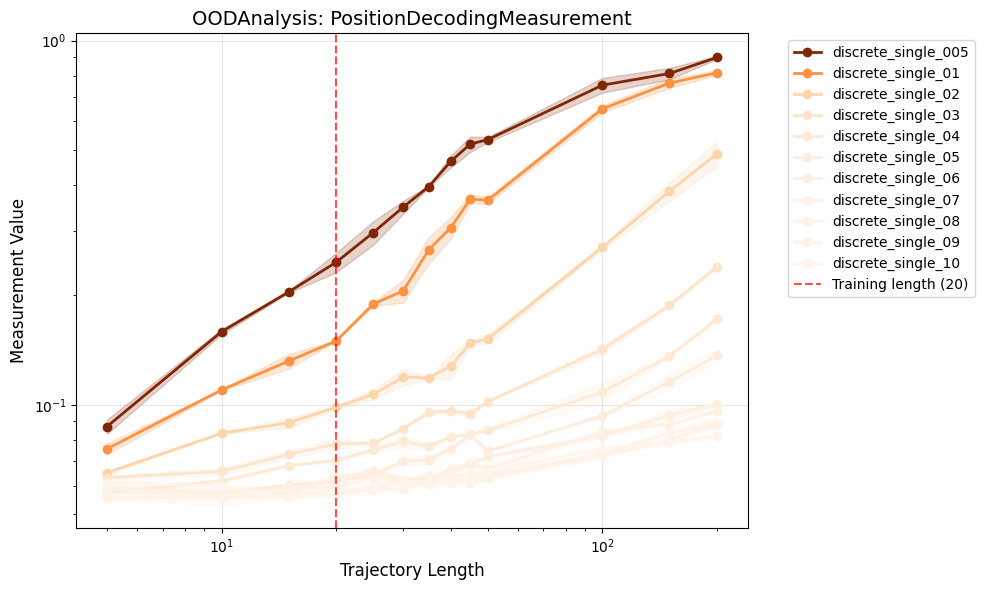

In [20]:
from timescales.analysis.plotting import plot_sweep_results, create_color_mapping

colors = create_color_mapping(models, "Oranges", ["timescales_config", "values"])


plot_sweep_results(results, log_x=True, log_y=True, colors=colors)